## Zimnat Insurance Product Recommendation Challenge

In [2]:
!pip install xgboost

In [1]:
# Importing all the Required Libraries

from sklearn.metrics import classification_report, accuracy_score, make_scorer, f1_score, log_loss
import warnings
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

warnings.filterwarnings('ignore')

# Setting Random State
RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)


# Installing optuna - Only for Google Collab Environment
#!pip install optuna


In [3]:
# Importing the data to pandas DataFrame
df_train = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')


In [4]:
print("Training Set dimesions: ", df_train.shape)
print("Test Set dimesions: ", df_test.shape)


Training Set dimesions:  (29132, 29)
Test Set dimesions:  (10000, 29)


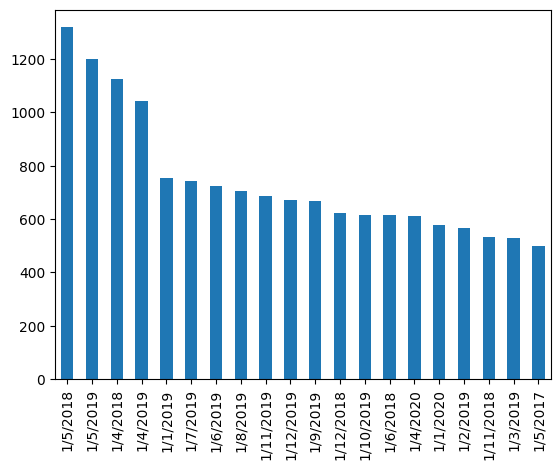

In [5]:
# Checking for Missing Values
df_train['join_date'].value_counts().sort_values(
    ascending=False).head(20).plot(kind="bar")


In [6]:
# checking for the most common date and imputing by most common
df_train['join_date'].fillna(df_train['join_date'].mode()[
                             0], inplace=True, axis=0)
df_test['join_date'].fillna(df_test['join_date'].mode()[0], inplace=True)


In [7]:
# Checking the number of Categories for Categorical Columns

for cols in df_train.columns:
    if df_train[cols].dtype == "O" and (cols not in ["ID", "join_date"]):
        print("Variable:", cols, " Number of Categories:",
              len(df_train[cols].value_counts()))


Variable: sex  Number of Categories: 2
Variable: marital_status  Number of Categories: 8
Variable: branch_code  Number of Categories: 15
Variable: occupation_code  Number of Categories: 233
Variable: occupation_category_code  Number of Categories: 6


In [8]:
# One-hot encoding for categories where we do not have many categories
cols = ['sex', 'marital_status', 'branch_code', 'occupation_category_code']
df_train = pd.get_dummies(df_train, columns=cols, prefix=cols)
df_test = pd.get_dummies(df_test, columns=cols, prefix=cols)

# Feature Engineering ------- Creating additional features

for df in [df_train, df_test]:
    df['day_joined'] = pd.DatetimeIndex(df['join_date']).day
    df['month_joined'] = pd.DatetimeIndex(df['join_date']).month
    df['year_joined'] = pd.DatetimeIndex(df['join_date']).year
    df['Age_at_join'] = df['year_joined'] - df['birth_year']
    df['time_elapsed_joined'] = (pd.to_datetime(
        '08/01/2020') - pd.DatetimeIndex(df['join_date'])).days
    df.drop(columns='join_date', inplace=True)


# We will only encode the top 95% of categories for the occupation code as there are too may categories to do one-hot
value_cum = df_train.occupation_code.value_counts().sort_values(
    ascending=False).cumsum()/df_train.shape[0]
topn_encode = value_cum[value_cum < 0.95]

topn = list(topn_encode.index)

for df in [df_train, df_test]:
    for categories in topn:
        df['occupation_code_' +
            categories] = np.where(df['occupation_code'] == categories, 1, 0)
    df.drop(columns='occupation_code', inplace=True)


In [9]:
print("Training Set dimesions: ", df_train.shape)
print("Test Set dimesions: ", df_test.shape)


Training Set dimesions:  (29132, 110)
Test Set dimesions:  (10000, 110)


In [10]:
# Setting up the dataset for use in the model
product_cols = ['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW',
                'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']

# Converting product to numeric label
product_ref = dict()
for i, x in enumerate(product_cols):
    product_ref[x] = i


In [11]:
# Converting the dataframe to duplicate observations across different products for the same ID
transpose_df = pd.melt(
    df_train, id_vars=['ID'], value_vars=product_cols).sort_values('ID')
transpose_df = transpose_df.loc[transpose_df.value == 1]

# Merging to main training set
merged_df = pd.merge(df_train, transpose_df, on='ID', how='left')

# Where target product in row, setting the value for product to zero


def Replace_Targets(df):
    for product in product_cols:
        if df[product] == 1 and df['variable'] == product:
            df[product] = 0

    return df


merged_df = merged_df.apply(Replace_Targets, axis=1)

# Cleaning up and remapping products to numeric values
merged_df.rename(columns={'variable': 'Target'}, inplace=True)
merged_df.drop(columns=['value'], inplace=True)
merged_df['Target'] = merged_df['Target'].map(product_ref)


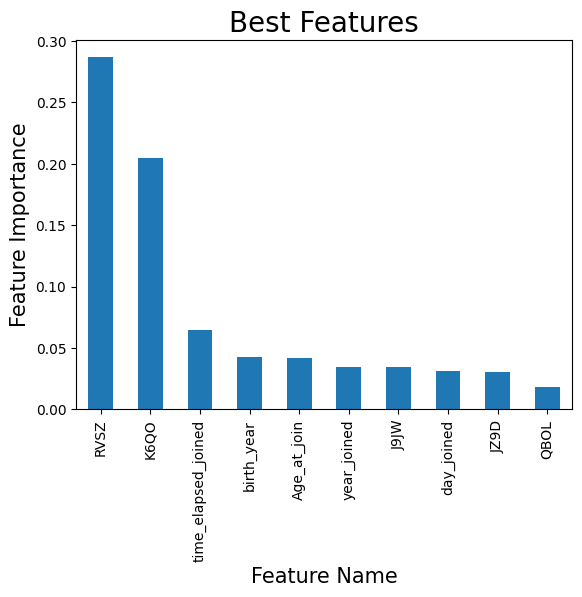

In [12]:
# Feature selection using RandomForestClassifer
Best_Features = RandomForestClassifier().fit(merged_df.drop(
    columns=["ID", "Target"]), merged_df.Target).feature_importances_

# Creating X and Y dataframes
X = merged_df.drop(columns=["ID", "Target"])
y = merged_df.Target

# Selecting the TopN Features --- Feature Selection

combined = dict(zip(X.columns, Best_Features))
FI = pd.Series(combined)


FI.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Best Features', fontsize=20)
plt.xlabel('Feature Name', fontsize=15)
plt.ylabel('Feature Importance', fontsize=15)


BF = list(FI.sort_values(ascending=False).head(10).index)


In [13]:
# Checking the distribution of classes
merged_df['Target'].value_counts().sort_values(ascending=False)


7     25328
14    21629
15     6833
8      2173
1      1780
17     1425
18     1418
20     1102
19      902
10      838
11      539
6       431
9       354
4       339
12      324
3       316
16      311
2       157
13      110
0        40
5         4
Name: Target, dtype: int64

In [14]:
# Oversampling classes using SMOTE
from imblearn.over_sampling import SMOTE
desired_classes = {5: 50, 0: 100, 13: 200,
                   2: 300, 19: 3000, 4: 700, 6: 800, 3: 700}
sm = SMOTE(random_state=RANDOM_STATE,
           sampling_strategy=desired_classes, k_neighbors=3)
X_res, y_res = sm.fit_resample(X, y)


In [15]:
# Training the model

import xgboost as xgb
from sklearn.model_selection import train_test_split

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=RANDOM_STATE)

# Fitting the Model
params = {'objective': 'multi:softprob', 'num_class': 21, 'max_depth': 9,
          'eta': 0.20, 'booster': 'dart', 'reg_lambda': 30,
          'colsample_bytre': 0.35, 'subsample': 0.85, 'eval_metric': 'mlogloss', 'n_threads': 2}
num_boost_round = 999
early_stopping = 10


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

evals = [(dtrain, 'Train'), (dtest, 'Test')]

In [16]:
# type of evals
print(type(evals))

<class 'list'>


In [ ]:


model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    early_stopping_rounds=early_stopping
)


In [ ]:
# Saving the model
import pickle
file_name = "Models/xgboost.pkl"

# save
pickle.dump(model, open(file_name, "wb"))


In [17]:
# Load Model
import pickle
file_name = "Models/xgboost.pkl"
model = pickle.load(open(file_name, "rb"))

In [18]:
# convert to list
model_columns = list(model.feature_names)

In [19]:
# Making predictions of Test Set
X_test1 = df_test.drop(columns=['ID'])

# reindexing the columns, Change the order of final_test to match the order of the model
final_test = xgb.DMatrix(X_test1.reindex(columns=model_columns))

pred_prob = model.predict(final_test, ntree_limit=159)


In [20]:
# save predictions to file
pred_prob_file = pd.DataFrame(pred_prob)

In [21]:
pred_prob_file.to_csv('pred_prob_file.csv', index=False)

In [22]:
def submission(predict_prob, classes, df_test):
    ''' Creates Submission Files from 
        Probability Outputs, Product names list and 
        Test file for ID and existing product Extraction'''

    # ID Counter
    counter = 0
    # Output dictionary
    output = {'ID X PCODE': [], 'Label': []}

    # Iterating over ID values in test data
    for idd in df_test['ID'].values:
        # Iterating over all probabilities per row
        for i, prob in enumerate(predict_prob[counter]):
            # Setting product name
            product_name = classes[i]
            # Checking if current ID already has product, and set prob = 1 if so
            if df_test.loc[df_test['ID'] == idd, product_name].values[0] == 1:
                prob = 1
            output['ID X PCODE'] = output['ID X PCODE'] + \
                [str(idd) + " X " + str(product_name)]
            output['Label'] = output['Label'] + [prob]
        counter += 1
    return output


In [23]:
output = submission(pred_prob, product_cols, df_test)

In [24]:
df_submission = pd.DataFrame.from_dict(output)


In [25]:
df_submission.to_csv("data/Predictions.csv", index=False)

In [26]:
id_x_pcode = pd.read_csv("data/Predictions.csv")


In [27]:
# split ID and PCODE from ID X PCODE and make a new dataframe
id_x_pcode[['ID', 'PCODE']] = id_x_pcode['ID X PCODE'].str.split(' X ', expand=True)

In [28]:
# remove ID X PCODE column and change the order of columns as ID, PCODE, Label
id_x_pcode = id_x_pcode[['ID', 'PCODE', 'Label']]

In [29]:
# save the dataframe to csv file
id_x_pcode.to_csv("data/id_pcode_label.csv", index=False)

In [30]:
# read the csv file
id_pcode_label = pd.read_csv("data/id_pcode_label.csv")

In [31]:
id_pcode_label.head(50)

,ID,PCODE,Label
0,F86J5PC,P5DA,0.000017
1,F86J5PC,RIBP,0.000153
2,F86J5PC,8NN1,0.000014
3,F86J5PC,7POT,0.000079
4,F86J5PC,66FJ,0.000071
5,F86J5PC,GYSR,0.000018
6,F86J5PC,SOP4,0.000066
7,F86J5PC,RVSZ,1.000000
8,F86J5PC,PYUQ,0.000541
9,F86J5PC,LJR9,0.000026


In [32]:
# for each ID print the 5 max labels
id_pcode_top5=id_pcode_label.groupby('ID').apply(lambda x: x.nlargest(5, 'Label')).reset_index(drop=True)

In [6]:
# save the dataframe to csv file
id_pcode_top5.to_csv("data/id_pcode_top5.csv", index=False)

NameError: name 'id_pcode_top5' is not defined

In [3]:
# read the csv file
id_pcode_top5_read = pd.read_csv("data/id_pcode_top5.csv")

In [5]:
# input the ID and print the top 5 labels
input_id = input("Enter ID: ")
id_pcode_top5_read.loc[id_pcode_top5_read['ID'] == str(input_id)]

,ID,PCODE,Label
21285,F86J5PC,RVSZ,1.000000
21286,F86J5PC,K6QO,0.989137
21287,F86J5PC,QBOL,0.006499
21288,F86J5PC,GHYX,0.002122
21289,F86J5PC,ECY3,0.000951
